# Repetition test

The goal of this notebook it to check the optimal delays and/or repetition rate for dynamical decoupling schemes.

## Imports

In [1]:
# Qiskit module
from qiskit import QuantumCircuit

# Qiskit tools for running and monitoring jobs
from qiskit import execute, transpile
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Dynamical decoupling sequences
from qiskit.ignis.mitigation.dd.sequences import XY4PulseDynamicalDecouplingSequence, XY4DynamicalDecouplingSequence
from qiskit.ignis.mitigation.dd.passes import DelayToDynamicalDecouplingSequencePass
from qiskit.converters import dag_to_circuit, circuit_to_dag

In [2]:
# Load IBMQ Account data
from qiskit import IBMQ
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='default')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()

## Circuit creation

In [3]:
DT_ALIGNEMENT: int = 16

def create_circuit(qubit: int, repetitions: int, total_time_dt: int) -> QuantumCircuit:
    total_time_alignement = total_time_dt // DT_ALIGNEMENT
    aligned_time_per_repetition = total_time_alignement // repetitions
    
    circ = QuantumCircuit(7, 1)
    circ.h(qubit)
    for _ in range(repetitions):
        circ.delay(aligned_time_per_repetition * DT_ALIGNEMENT, qarg=[qubit], unit="dt")
    circ.h(qubit)
    circ.measure(qubit, 0)
    return circ

In [48]:
repetitions = list(range(1, 51))
R = 3
total_time_dt = int(20e-6 / (2/9 * 1e-9))

circuits = [create_circuit(0, rep, total_time_dt) for rep in repetitions]

In [49]:
dd_sequence = XY4DynamicalDecouplingSequence(backend, symmetric=True)
transpiler_pass = DelayToDynamicalDecouplingSequencePass(
    dd_sequence, backend.properties(), backend.configuration().dt
)

dd_circuits = [dag_to_circuit(transpiler_pass.run(circuit_to_dag(c))) for c in circuits]

In [50]:
dd_transpiled_circuits = [transpile(c, backend, optimization_level=0) for c in dd_circuits for _ in range(R)]

In [57]:
job_kwargs = {
    "initial_layout": list(range(7)),
    "shots": 8192,
    "job_share_level": "global",
}
job = execute(dd_transpiled_circuits, backend, **job_kwargs)
# Repeat = 1
#job = backend.retrieve_job("604e9a2e0e63ea7fcd37522a")
# Repeat = 1
#job = backend.retrieve_job("604f2b0a46862b0209220de6")
# Repeat = 2
#job = backend.retrieve_job("604f30a1edbb5bfce79d8a09")
# Repeat = 2
#job = backend.retrieve_job("604f335a0e63eaaa5a3757b5")
# Repeat = 3
#job = backend.retrieve_job("604f366f04f5a59514691486")
# Repeat = 3
#job = backend.retrieve_job("604f38fa9033279dcd9dd82d")
print(job.job_id())

604f38fa9033279dcd9dd82d


In [58]:
job_monitor(job)

Job Status: job has successfully run


In [53]:
result = job.result()

fidelities = list()

for i, r in enumerate(repetitions):
    fidelities.append(sum(result.get_counts(R*i + j).int_outcomes().get(0, 0) for j in range(R)) / (R * 8192))

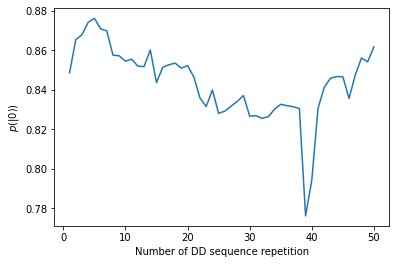

In [54]:
import matplotlib.pyplot as plt
plt.plot(repetitions, fidelities)
plt.xlabel("Number of DD sequence repetition")
plt.ylabel(r"$p\left(\vert0\rangle\right)$")
plt.show()

In [61]:
import numpy as np

fidelities = np.zeros((len(repetitions),))
for job_id, reps in [
    ("604e9a2e0e63ea7fcd37522a", 1),
    ("604f2b0a46862b0209220de6", 1),
    ("604f30a1edbb5bfce79d8a09", 2),
    ("604f335a0e63eaaa5a3757b5", 2), 
    ("604f366f04f5a59514691486", 3),
    ("604f38fa9033279dcd9dd82d", 3),
]:
    job = backend.retrieve_job(job_id)
    result = job.result()
    for i in range(len(repetitions)):
        fidelities[i] += sum(
            result.get_counts(reps*i + j).int_outcomes().get(0, 0) 
            for j in range(reps)
        ) / 8192

fidelities /= 12

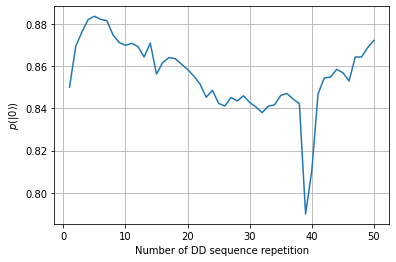

In [62]:
plt.plot(repetitions, fidelities)
plt.xlabel("Number of DD sequence repetition")
plt.ylabel(r"$p\left(\vert0\rangle\right)$")
plt.grid()
plt.show()

In [75]:
total_time_dt = int(20e-6 / (2/9 * 1e-9))
total_time_alignement = total_time_dt // DT_ALIGNEMENT
aligned_time_per_repetition = [total_time_alignement // r for r in repetitions]

fig = plt.gcf()
fig.set_size_inches(18.5, 5)
plt.semilogx(aligned_time_per_repetition, fidelities, base=10, marker="+")
plt.xlabel("Time per repetition (dt)")
plt.ylabel(r"$p\left(\vert0\rangle\right)$")
plt.grid(which="both")
plt.show()